In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_pandas

% matplotlib inline

In [2]:
%cd C:\\Users\\sebsa\\Documents\\Centrale Paris\\3A\\OEN\\Projet Synthese\\data

C:\Users\sebsa\Documents\Centrale Paris\3A\OEN\Projet Synthese\data


## Read and format data

### ASU

In [3]:
df_ASU = pd.read_excel('Sites Europe.xlsx', encoding='utf-8')
df_ASU = df_ASU[np.isfinite(df_ASU['Site Latitude'])]
df_ASU = df_ASU[np.isfinite(df_ASU['Site Longitude'])]
# df_ASU.Country.fillna(method='ffill', inplace=True)
df_ASU.head()

,Country,Continent,Site,Site Latitude,Site Longitude,Plant,Nominal_Power(MW)
1,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Combo,1.913325
2,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Sigma,0.659147
3,Austria,CENTRAL EUROPE,Schwechat,48.146024,16.480538,P_Schwechat,1.464799
4,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Air Gas pipelines system,NaN
5,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Benelux total ASU,NaN


In [4]:
def conv2lat(float_number):
    zou = float_number
    i = 0
    while abs(zou) != 0.:
        zou = zou//10
        i += 1
    return float_number / (10**(i-2))

def conv2lon(float_number):
    zou = float_number
    i = 0
    while ((abs(zou) != 0.) & (abs(zou) != 1.)):
        zou = zou//10
        i += 1
    return float_number / (10**(i-1))

In [5]:
# tqdm.pandas()
# df_ASU['lat'] = df_ASU['Site Latitude'].progress_apply(conv2lat)
# df_ASU['lon'] = df_ASU['Site Longitude'].progress_apply(conv2lon)

df_ASU.rename(columns={'Site Latitude':'lat', 'Site Longitude':'lon'}, inplace=True)

In [6]:
df_ASU.head(15)

,Country,Continent,Site,lat,lon,Plant,Nominal_Power(MW)
1,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Combo,1.913325
2,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Sigma,0.659147
3,Austria,CENTRAL EUROPE,Schwechat,48.146024,16.480538,P_Schwechat,1.464799
4,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Air Gas pipelines system,NaN
5,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Benelux total ASU,NaN
6,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen ASU,9.368968
7,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Jupiter 1,NaN
8,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Jupiter 2,NaN
9,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Syngas II,NaN
10,Belgium,NORTHERN EUROPE,Brussels,51.322639,4.284417,P_HyCO pipelines system,NaN


### Buses

In [7]:
path = 'reseau/buses_formatted.csv'
buses = pd.read_csv(path, index_col=0)
buses.head()

,bus_id,station_id,voltage,dc,symbol,lon,lat
0,1,2,380.0,f,Substation,43.714600,36.129002
1,2,3,380.0,f,Substation,43.967285,35.460670
2,3,4,380.0,f,Substation,44.813232,31.456782
3,4,5,380.0,f,Substation,43.967285,32.184911
4,5,6,380.0,f,Substation,44.011230,32.704111


## Associate

In [8]:
from math import cos, asin, sqrt
from tqdm import tqdm

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest(data, v):
    list_dist = []
    for p in data:
        list_dist.append(distance(v['lat'],v['lon'],p['lat'],p['lon']))
    return (list_dist.index(min(list_dist)), min(list_dist))
#     return min(data, key=lambda p: distance(v['lat'],v['lon'],p['lat'],p['lon']))

tempDataList = [{'lat': 39.7612992, 'lon': -86.1519681}, 
                {'lat': 39.762241,  'lon': -86.158436 }, 
                {'lat': 39.7622292, 'lon': -86.1578917}]

v = {'lat': 39.7622290, 'lon': -86.1519750}
index_bus, dist = closest(tempDataList, v)
print(index_bus)
print(dist)

0
0.10339070310220466


In [9]:
datalist = buses.to_dict(orient='records')

for index, row in tqdm(df_ASU.iterrows()):
    mypoint = {'lat': row['lat'], 'lon': row['lon']}
    index_bus, dist = closest(datalist, mypoint)
    df_ASU.set_value(index, 'bus_id', buses.iloc[index_bus]['bus_id'])
    df_ASU.set_value(index, 'dist_bus_km', dist)

125it [00:01, 65.37it/s]


In [10]:
df_ASU.bus_id = df_ASU.bus_id.astype('int64')

In [11]:
df_ASU.head(15)

,Country,Continent,Site,lat,lon,Plant,Nominal_Power(MW),bus_id,dist_bus_km
1,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Combo,1.913325,4331,20.907934
2,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Sigma,0.659147,4331,20.907934
3,Austria,CENTRAL EUROPE,Schwechat,48.146024,16.480538,P_Schwechat,1.464799,4329,9.231421
4,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Air Gas pipelines system,NaN,5363,2.235958
5,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Benelux total ASU,NaN,5363,2.235958
6,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen ASU,9.368968,5363,2.235958
7,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Jupiter 1,NaN,5363,2.235958
8,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Jupiter 2,NaN,5363,2.235958
9,Belgium,NORTHERN EUROPE,Antwerpen,51.322639,4.284417,P_Antwerpen Syngas II,NaN,5363,2.235958
10,Belgium,NORTHERN EUROPE,Brussels,51.322639,4.284417,P_HyCO pipelines system,NaN,5363,2.235958


In [12]:
df_ASU.to_csv('all_ASU_with_bus.csv', encoding='utf-8')

## Explore

In [9]:
df_ASU = pd.read_csv('all_ASU_with_bus.csv', index_col=0)
df_ASU.head()

,Country,Continent,Site,lat,lon,Plant,Nominal_Power(MW),bus_id,dist_bus_km
1,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Combo,1.913325,4331,20.907934
2,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Sigma,0.659147,4331,20.907934
3,Austria,CENTRAL EUROPE,Schwechat,48.146024,16.480538,P_Schwechat,1.464799,4329,9.231421
4,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Air Gas pipelines system,NaN,5363,2.235958
5,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Benelux total ASU,NaN,5363,2.235958


In [10]:
df_ASU.dist_bus_km.describe()

count    125.000000
mean      11.005916
std       29.256674
min        0.775336
25%        4.345256
50%        6.817853
75%        9.861513
max      322.657737
Name: dist_bus_km, dtype: float64

Number of points under 200 km : 124
Number of points above 200 km : 1


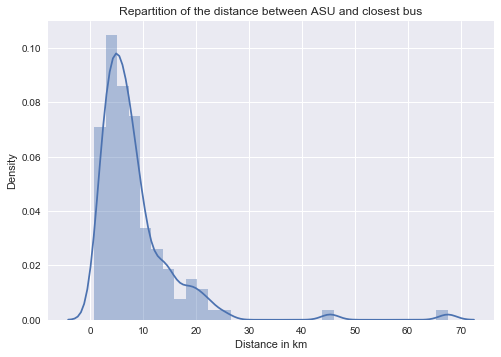

In [11]:
sns.set(color_codes=True)

limit = 200
print('Number of points under {0} km : {1}'
      .format(limit,df_ASU.dist_bus_km[df_ASU.dist_bus_km <= limit].count()))
print('Number of points above {0} km : {1}'
      .format(limit,df_ASU.dist_bus_km[df_ASU.dist_bus_km > limit].count()))

sns.distplot(df_ASU.dist_bus_km[df_ASU.dist_bus_km <= limit])
sns.plt.title('Repartition of the distance between ASU and closest bus')
sns.plt.xlabel('Distance in km')
sns.plt.ylabel('Density')

## Add nominal power to bus csv

In [12]:
path = 'buses_formatted_with_capacity.csv'
buses = pd.read_csv(path, index_col=0)
buses.head()

,bus_id,station_id,voltage,dc,symbol,lon,lat,electrical_capacity_solar,electrical_capacity_wind
0,1,2,380.0,f,Substation,43.714600,36.129002,225.12687,0.0
1,2,3,380.0,f,Substation,43.967285,35.460670,0.00000,0.0
2,3,4,380.0,f,Substation,44.813232,31.456782,0.00000,0.0
3,4,5,380.0,f,Substation,43.967285,32.184911,0.00000,0.0
4,5,6,380.0,f,Substation,44.011230,32.704111,0.00000,0.0


In [13]:
df_ASU.head()

,Country,Continent,Site,lat,lon,Plant,Nominal_Power(MW),bus_id,dist_bus_km
1,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Combo,1.913325,4331,20.907934
2,Austria,CENTRAL EUROPE,Donawitz,47.380020,15.063486,P_Donawitz_Sigma,0.659147,4331,20.907934
3,Austria,CENTRAL EUROPE,Schwechat,48.146024,16.480538,P_Schwechat,1.464799,4329,9.231421
4,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Air Gas pipelines system,NaN,5363,2.235958
5,Belgium,NORTHERN EUROPE,Air Gas pipelines system,51.322639,4.284417,P_Benelux total ASU,NaN,5363,2.235958


In [14]:
df_ASU_to_merge = df_ASU[['bus_id','Nominal_Power(MW)']].groupby('bus_id', as_index=False).sum()
df_ASU_to_merge.head()

,bus_id,Nominal_Power(MW)
0,177,9.619322
1,214,10.289817
2,231,1.707690
3,420,0.814058
4,424,0.719383


In [15]:
buses_merged = buses.merge(df_ASU_to_merge, how='left', on='bus_id').fillna(value=0.)
buses_merged.head()

,bus_id,station_id,voltage,dc,symbol,lon,lat,electrical_capacity_solar,electrical_capacity_wind,Nominal_Power(MW)
0,1,2,380.0,f,Substation,43.714600,36.129002,225.12687,0.0,0.0
1,2,3,380.0,f,Substation,43.967285,35.460670,0.00000,0.0,0.0
2,3,4,380.0,f,Substation,44.813232,31.456782,0.00000,0.0,0.0
3,4,5,380.0,f,Substation,43.967285,32.184911,0.00000,0.0,0.0
4,5,6,380.0,f,Substation,44.011230,32.704111,0.00000,0.0,0.0


In [16]:
buses_merged.rename(columns={'electrical_capacity_solar':'electrical_capacity_solar',
                            'electrical_capacity_wind':'electrical_capacity_wind',
                            'Nominal_Power(MW)':'Nominal_Power_ASU'}, inplace=True)

In [17]:
buses_merged['Nominal_Power_ASU'].describe()

count    7893.000000
mean        0.028971
std         0.438654
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.259776
Name: Nominal_Power_ASU, dtype: float64

In [18]:
buses_merged.head()

,bus_id,station_id,voltage,dc,symbol,lon,lat,electrical_capacity_solar,electrical_capacity_wind,Nominal_Power_ASU
0,1,2,380.0,f,Substation,43.714600,36.129002,225.12687,0.0,0.0
1,2,3,380.0,f,Substation,43.967285,35.460670,0.00000,0.0,0.0
2,3,4,380.0,f,Substation,44.813232,31.456782,0.00000,0.0,0.0
3,4,5,380.0,f,Substation,43.967285,32.184911,0.00000,0.0,0.0
4,5,6,380.0,f,Substation,44.011230,32.704111,0.00000,0.0,0.0


In [20]:
buses_merged.to_csv('buses_formatted_with_capacity_and_ASUpower.csv', encoding='utf-8')